# Определение возраста покупателей

Целью проекта является построение и обучение системы компьютерного зрения для обработки фотографий покупателей. Данная система должна определять приблизительный возраст клиентов, чтобы:
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

2. Контролировать добросовестность кассиров при продаже алкоголя.

## Загрузка данных, EDA и сплиты 

In [1]:
import pandas as pd
#import tensorflow

Датасет APPA-REAL содержит 7 591 изображение.

Разделение на выборки задано заранее: train — 4 113, valid — 1 500, test — 1 978.

In [2]:
train_labels = pd.read_csv('appa-real-release/gt_avg_train.csv')
valid_labels = pd.read_csv("appa-real-release/gt_avg_valid.csv")
test_labels  = pd.read_csv("appa-real-release/gt_avg_test.csv")

In [3]:
print("train:", train_labels.shape)
print("valid:", valid_labels.shape)
print("test :", test_labels.shape)
print("total:", len(train_labels) + len(valid_labels) + len(test_labels))

train: (4113, 5)
valid: (1500, 5)
test : (1978, 5)
total: 7591


Для EDA объединим все сплиты в один датафрейм.

In [4]:
all_labels = pd.concat([
    train_labels.assign(split="train"),
    valid_labels.assign(split="valid"),
    test_labels.assign(split="test"),
], ignore_index=True)

all_labels["split"].value_counts()


split
train    4113
test     1978
valid    1500
Name: count, dtype: int64

In [5]:
all_labels.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age,split
0,000000.jpg,36,5.000000,1.146423,4,train
1,000001.jpg,63,20.079365,4.096819,18,train
2,000002.jpg,38,76.815789,6.133009,80,train
3,000003.jpg,38,55.657895,7.864653,50,train
4,000004.jpg,15,17.666667,3.457222,17,train


In [6]:
all_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         7591 non-null   object 
 1   num_ratings       7591 non-null   int64  
 2   apparent_age_avg  7591 non-null   float64
 3   apparent_age_std  7591 non-null   float64
 4   real_age          7591 non-null   int64  
 5   split             7591 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 356.0+ KB


Рассмотрим структуру таблицы и базовые статистики. Целевая переменная — `real_age`. Также в процессе сбора этих данных предусматривалась оценка возраста оценщиками, это представлено в 2-ух дополнительных признаках - `num_ratings`(количество оценщиков) и `apparent_age_std` (средняя оценка возраста оценщиков). Для обучения данные признаки не понадобятся, но оставим их для EDA.

In [7]:
all_labels.describe()

,num_ratings,apparent_age_avg,apparent_age_std,real_age
count,7591.000000,7591.000000,7591.000000,7591.000000
mean,34.337505,30.965106,4.339865,31.201159
std,27.788812,15.627235,1.877274,17.145060
min,10.000000,0.923077,0.000000,1.000000
25%,14.000000,21.974679,3.149931,20.000000
50%,37.000000,28.727273,4.357660,29.000000
75%,39.000000,38.975973,5.509453,41.000000
max,609.000000,95.567568,14.510423,100.000000


В датасете 7 591 изображение. `real_age` лежит в диапазоне 1–100, медиана около 29, среднее около 31, что соответствует смещению выборки в сторону молодых взрослых. 

При этом разброс оценок `apparent_age_std` в среднем около 4–5 лет (а максимум до ~14), значит часть фотографий по возрасту визуально неоднозначна — на них модель, скорее всего, будет ошибаться сильнее. `num_ratings` в среднем около 34 голосов на фото (медиана ~37), то есть для большинства изображений `apparent-age` оценён достаточно большим числом людей, поэтому среднее можно оценить как стабильное и большой разброс связан именно с неоднозначностью фото.

Подтвердим низкую нестабильность среднего (`standard error of the mean - SE`) для нашего случая по формуле:

$$
SE \approx \frac{\text{apparent\_age\_std}}{\sqrt{\text{num\_ratings}}}
$$


In [8]:
import numpy as np

all_labels["apparent_age_se"] = all_labels["apparent_age_std"] / np.sqrt(all_labels["num_ratings"])
all_labels["apparent_age_se"].describe()

count    7591.000000
mean        0.846983
std         0.420015
min         0.000000
25%         0.562116
50%         0.824192
75%         1.102517
max         3.746575
Name: apparent_age_se, dtype: float64

`SE` в среднем окло 0.85 - что можно оценить как низкий показатель. Соответственно высокий разброс для некоторых фотографий связан с их неоднозначностью. Рассмотрим их.

In [9]:
top_amb = (all_labels
           .sort_values("apparent_age_se", ascending=False)
           .head(10)[["file_name", "num_ratings", "apparent_age_std", "apparent_age_se",
                      "real_age", "apparent_age_avg", "split"]])

top_amb


,file_name,num_ratings,apparent_age_std,apparent_age_se,real_age,apparent_age_avg,split
4712,004712.jpg,15,14.510423,3.746575,34,27.533333,valid
85,000085.jpg,15,9.984273,2.577928,51,41.400000,train
5583,005583.jpg,15,9.910072,2.558770,55,45.066667,valid
1268,001268.jpg,21,11.298757,2.465591,54,39.190476,train
3923,003923.jpg,16,9.669324,2.417331,43,38.187500,train
2480,002480.jpg,28,12.604012,2.381934,39,30.750000,train
2946,002946.jpg,18,10.032627,2.364713,25,35.777778,train
2192,002192.jpg,13,8.410159,2.332558,50,44.307692,train
805,000805.jpg,15,8.910668,2.300725,39,36.400000,train
4316,004316.jpg,14,8.593378,2.296677,56,53.000000,valid


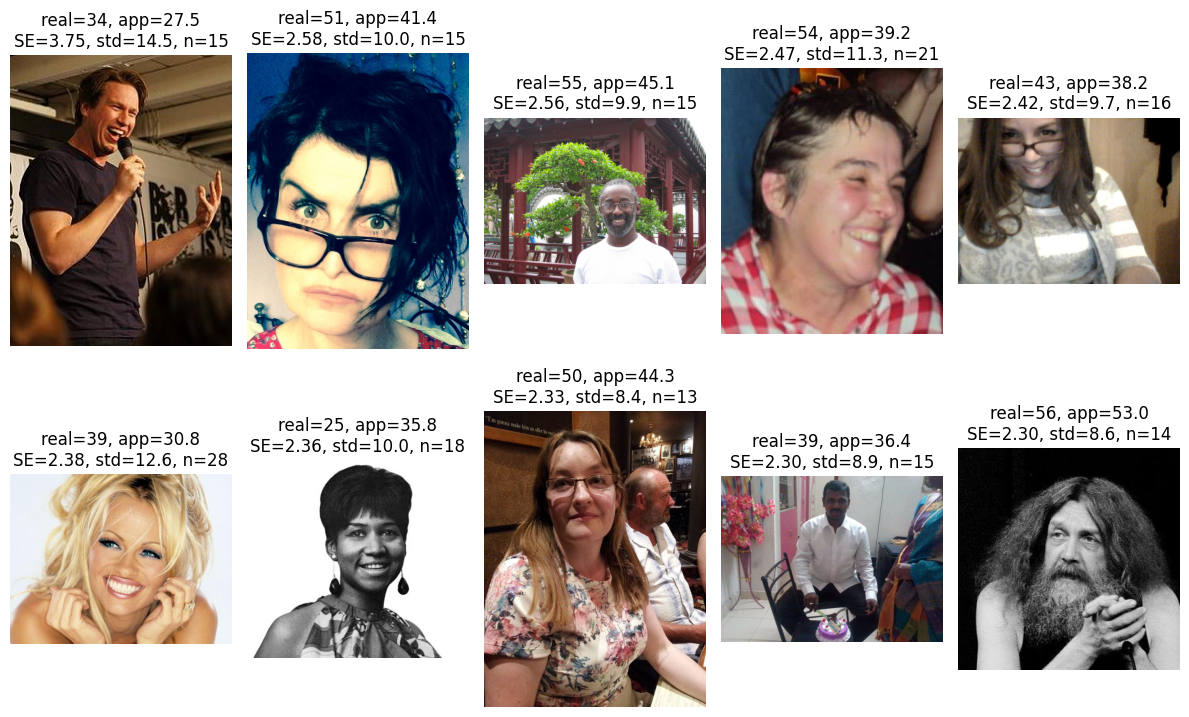

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

base_dir = "appa-real-release"  

top_amb = (all_labels
           .sort_values("apparent_age_se", ascending=False)
           .head(10))

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(top_amb.iterrows(), 1):
    img_path = os.path.join(base_dir, row["split"], row["file_name"])
    img = Image.open(img_path)

    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(
        f"real={int(row['real_age'])}, app={row['apparent_age_avg']:.1f}\n"
        f"SE={row['apparent_age_se']:.2f}, std={row['apparent_age_std']:.1f}, n={int(row['num_ratings'])}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()



Данные фотографии являются наиболее проблемными с точки зрения определения возраста оценищиками.

Рассмотрим также вопрос пропусков и дубликатов.

In [11]:
(all_labels.isna().mean()
 .to_frame("missing")
 .style
 .format("{:.1%}")
 .background_gradient(cmap="coolwarm"))


,missing
file_name,0.0%
num_ratings,0.0%
apparent_age_avg,0.0%
apparent_age_std,0.0%
real_age,0.0%
split,0.0%
apparent_age_se,0.0%


In [12]:
all_labels.duplicated().sum()

np.int64(0)

In [13]:
train_set = set(train_labels["file_name"])
valid_set = set(valid_labels["file_name"])
test_set  = set(test_labels["file_name"])

print("train∩valid:", len(train_set & valid_set))
print("train∩test :", len(train_set & test_set))
print("valid∩test :", len(valid_set & test_set))


train∩valid: 0
train∩test : 0
valid∩test : 0


Пропусков, дубликатов и пересечений между сплитами не предусмотрено, предобработка не требуется.

Рассмотрим распределение целевого признака.

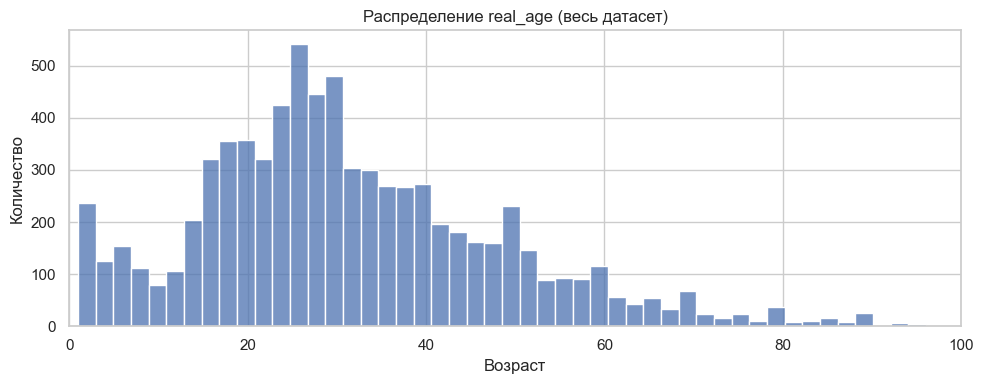

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 4))
sns.histplot(data=all_labels, x="real_age", bins=50, kde=False)
plt.title("Распределение real_age (весь датасет)")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


Распределение возрастов неравномерно: максимум частоты приходится на молодых взрослых (примерно 20–35 лет). Дальше наблюдается постепенное уменьшение частоты с возрастом и длинный “хвост” вправо. При этом у детей заметен отдельный локальный пик — это важно учитывать при интерпретации.

KDE удобно показывает общую форму распределения и позволяет сравнить сплиты.

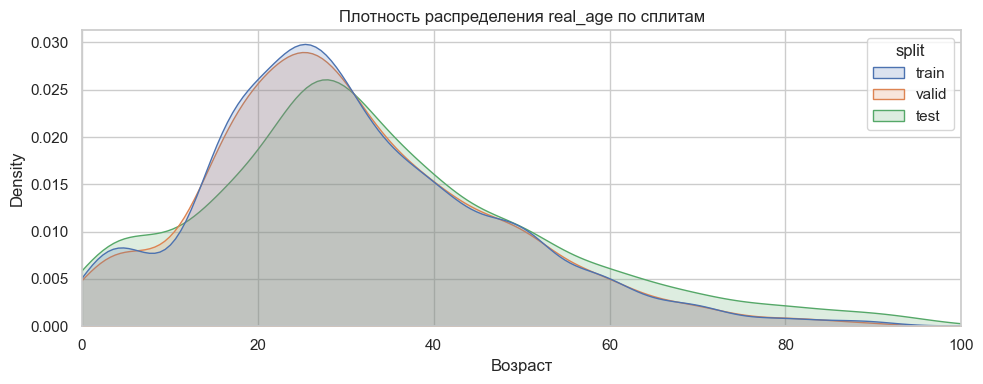

In [15]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=all_labels, x="real_age", hue="split", common_norm=False, fill=True, alpha=0.2)
plt.title("Плотность распределения real_age по сплитам")
plt.xlabel("Возраст")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


In [16]:
for s, d in all_labels.groupby("split"):
    print(s, "share age>=60:", (d["real_age"] >= 60).mean().round(3))


test share age>=60: 0.104
train share age>=60: 0.056
valid share age>=60: 0.056


В целом распределения по сплитам похожи, однако тестовая выборка содержит заметно большую долю возрастов 60+ (≈10.4% против ≈5.6% в train/valid). Это может привести к немного более высокой ошибке на тесте, так как старшие возраста представлены реже в обучении.

Дополнительно используем `boxplot` для сравнения медиан и разброса между сплитами.

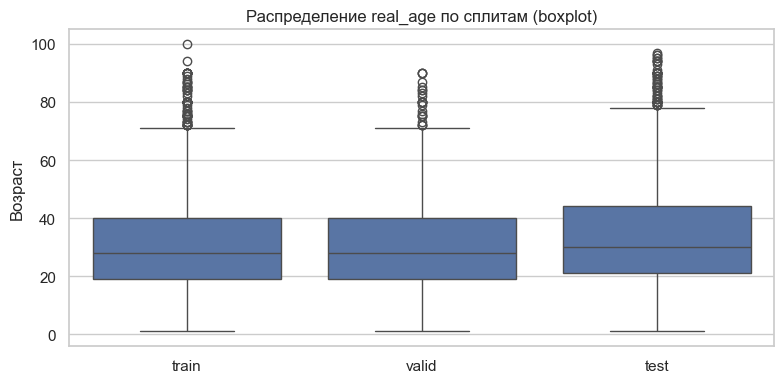

In [17]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=all_labels, x="split", y="real_age")
plt.title("Распределение real_age по сплитам (boxplot)")
plt.xlabel("")
plt.ylabel("Возраст")
plt.tight_layout()
plt.show()


На боксплоте видно, что медианы и межквартильные размахи у сплитов близки — “центральная” часть распределения сопоставима. При этом у тестовой выборки верхняя часть распределения выражена сильнее: больше точек в области высоких возрастов, что согласуется с тем, что доля 60+ в тесте выше, чем в train/valid.

In [18]:
top_ages = all_labels["real_age"].value_counts().head(15)
display(top_ages)

real_age
30    317
25    315
27    229
26    226
28    217
23    213
24    211
16    193
18    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: count, dtype: int64

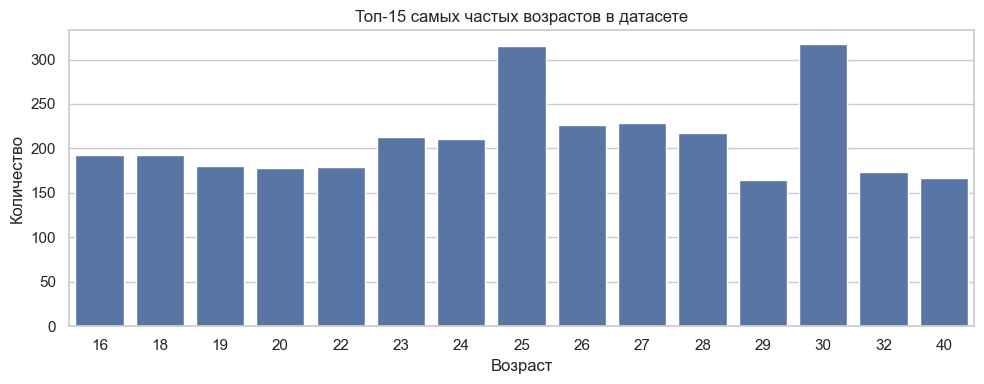

In [19]:
plt.figure(figsize=(10, 4))
sns.barplot(x=top_ages.index, y=top_ages.values)
plt.title("Топ-15 самых частых возрастов в датасете")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()


Дополнительно смотрим частоты по каждому целому возрасту.

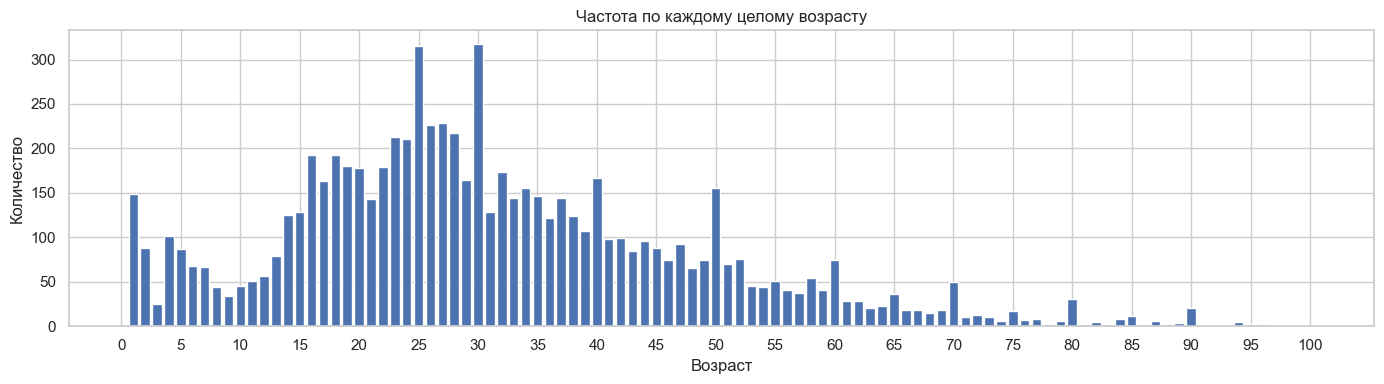

In [20]:
age_counts = all_labels["real_age"].value_counts().sort_index()

plt.figure(figsize=(14, 4))
plt.bar(age_counts.index, age_counts.values)
plt.title("Частота по каждому целому возрасту")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.xticks(range(0, 101, 5))  # подписи раз в 5 лет
plt.tight_layout()
plt.show()


Видны локальные пики на “круглых” значениях (например, 25 и 30), что может быть связано с округлением возраста при сборе/разметке данных.

Для целочисленного возраста гистограмма (особенно с шагом 1 год) лучше показывает локальные пики и «круглые» значения, где наблюдений действительно больше. KDE — это сглаженная оценка плотности: она удобна, чтобы увидеть общую форму распределения и сравнить сплиты, но отдельные пики может частично «размывать».

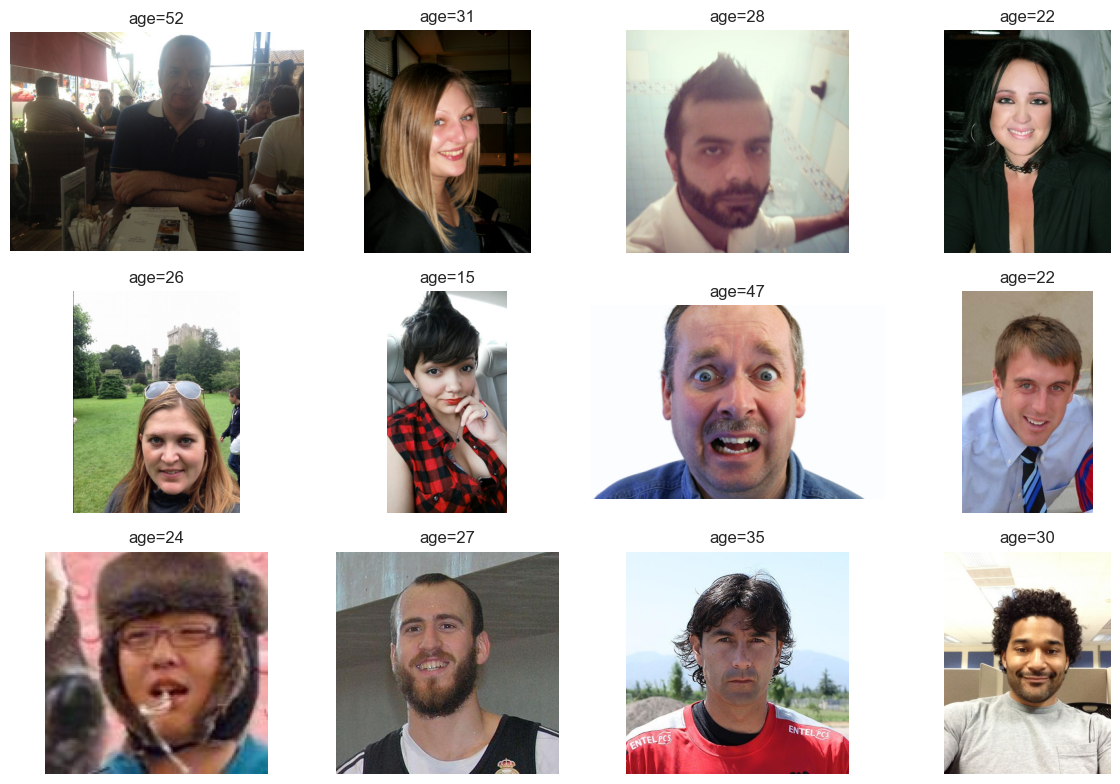

In [21]:
import os
from PIL import Image

sample = train_labels.sample(12, random_state=42)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows(), 1):
    img_path = os.path.join("appa-real-release/train", row["file_name"])
    img = Image.open(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(f'age={row["real_age"]}')
    plt.axis("off")
plt.tight_layout()
plt.show()


Печатаем примеры изображений, чтобы оценить качество данных: освещение, ракурсы, частичные перекрытия лица, различия в фоне и масштабе. Это влияет на качество модели и оправдывает использование аугментаций и предобученных CNN.

Таким образом, Датасет APPA-REAL содержит 7 591 изображение и заранее разбит на train/valid/test без заметного смещения распределений между сплитами. Возраст (real_age) распределён неравномерно: основная масса наблюдений приходится на молодых взрослых, у пожилых заметно меньше примеров, при этом у детей наблюдается локальный пик. По частотам целых возрастов видны выраженные пики на “круглых” значениях (например, 25 и 30), что похоже на эффект округления при разметке. Объём данных (~7.6k) для CV-задачи умеренный: обычно его достаточно, чтобы обучить модель на базе transfer learning, но из-за неравномерности по возрастам и возможного округления стоит ожидать, что ошибки на редких возрастах будут выше.

Итог EDA:

- **Объём данных:** 7 591 изображение; разбиение на train/valid/test задано заранее.
- **Целевая переменная:** `real_age` в диапазоне **1–100** (медиана ~**29**, среднее ~**31**), распределение смещено в сторону молодых взрослых; у пожилых наблюдений меньше, при этом у детей виден локальный пик.
- **Сплиты в целом похожи по центральной части распределения**, однако тестовая выборка содержит заметно большую долю старших возрастов: **60+ ≈ 10.4%** в *test* против **≈ 5.6%** в *train/valid*. Это может слегка повышать MAE на тесте из-за редкости старших возрастов в обучении.
- **Пики на “круглых” возрастах:** по частотам целых значений видны выраженные пики (например, **25** и **30**), что похоже на эффект округления возраста при сборе/разметке и может смещать предсказания к наиболее частым значениям.
- **Качество разметки apparent-age:** в среднем `num_ratings` достаточно велик (≈34), поэтому средние apparent-оценки устойчивы, но `apparent_age_std` показывает, что часть изображений визуально неоднозначна по возрасту — на таких примерах модель, вероятно, будет ошибаться сильнее.

**Вывод:** объём данных (~7.6k) для CV-задачи **умеренный** — обычно достаточен для обучения модели на базе *transfer learning* (предобученной CNN, например ResNet50), нормализации и аугментаций. При этом дисбаланс по возрастам, округление и повышенная доля 60+ в тесте задают “сложные зоны”, где ожидаемо выше ошибка.

Переходим к этапу подготовки к обучению.

## Подготовка к обучению

Рассмотрим 2 разные backbone-модели - `ResNet50`, как наиболее классическую, и `EfficientNet`, как наиболее современную.

In [23]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

2.7.1+cu118
CUDA available: True


Формируем кастомный датасет в стиле PyTorch: по `file_name` читаем изображение из папки, берём целевой возраст `real_age` как float32, применяем transform (нормализация, аугментации) и возвращаем пару (image, age) для DataLoader.

In [24]:
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset

class AgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["file_name"]
        img = Image.open(img_path).convert("RGB")
        y = torch.tensor(row["real_age"], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, y


Готовим преобразования изображений под две предобученные архитектуры. Для каждой модели берём “родной” `preprocess` из `weights.transforms()` (он задаёт правильный `resize`/`normalize` под веса). На `train` добавляем лёгкие аугментации, на `valid`/`test` оставляем только `preprocess`.

In [25]:
import torchvision.transforms as T
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

RESNET_W = ResNet50_Weights.DEFAULT
preprocess = RESNET_W.transforms()   

# train: добавляем аугментации + потом preprocess
train_tfms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    preprocess,
])

# valid/test: только preprocess (без аугментаций)
val_tfms = preprocess



In [26]:
EFFNET_W = EfficientNet_B0_Weights.DEFAULT
eff_preprocess = EFFNET_W.transforms()

train_tfms_eff = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    eff_preprocess,
])

val_tfms_eff = eff_preprocess

Задаём пути к папкам `train`/`valid`/`test` и создаём три датасета: для `train` используем `train_tfms` (с аугментациями), для `valid`/`test` — `val_tfms` (только preprocess). Так мы учимся на “разнообразных” данных, а оцениваем честно на неизменённых.

In [27]:
base_dir = r"appa-real-release"  

train_dir = rf"{base_dir}\train"
valid_dir = rf"{base_dir}\valid"
test_dir  = rf"{base_dir}\test"

train_ds = AgeDataset(train_labels, img_dir=train_dir, transform=train_tfms)
valid_ds = AgeDataset(valid_labels, img_dir=valid_dir, transform=val_tfms)
test_ds  = AgeDataset(test_labels,  img_dir=test_dir,  transform=val_tfms)


Оборачиваем датасеты в DataLoader, чтобы получать батчи.

`shuffle=True` только для `train` (чтобы модель не видела данные всегда в одном порядке)

`num_workers=0` — оставляем для стабильности на Windows/Jupyter

`pin_memory=pin` включается, если есть CUDA, чтобы быстрее грузить батчи на GPU

In [28]:
from torch.utils.data import DataLoader

pin = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=pin)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0, pin_memory=pin)



Аналогично создаём отдельные датасеты и DataLoader для EfficientNet — выделяем отдельные переменные *_eff, чтобы не смешивать пайплайны двух моделей.

In [29]:
train_ds_eff = AgeDataset(train_labels, img_dir=train_dir, transform=train_tfms_eff)
valid_ds_eff = AgeDataset(valid_labels, img_dir=valid_dir, transform=val_tfms_eff)
test_ds_eff  = AgeDataset(test_labels,  img_dir=test_dir,  transform=val_tfms_eff)

train_loader_eff = DataLoader(train_ds_eff, batch_size=32, shuffle=True,  num_workers=0, pin_memory=pin)
valid_loader_eff = DataLoader(valid_ds_eff, batch_size=64, shuffle=False, num_workers=0, pin_memory=pin)
test_loader_eff  = DataLoader(test_ds_eff,  batch_size=64, shuffle=False, num_workers=0, pin_memory=pin)

Загружаем две предобученные модели и заменяем их последний слой на Linear(..., 1), чтобы вместо классов модель предсказывала одно число — возраст.

In [30]:
import torch.nn as nn
from torchvision.models import resnet50

def make_resnet50_regressor(weights=RESNET_W):
    model = resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

In [32]:
from torchvision.models import efficientnet_b0

def make_effb0_regressor(weights=EFFNET_W):
    model = efficientnet_b0(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

Описываем цикл обучения для регрессии возраста: обучаем модель по MSELoss, а качество считаем метрикой MAE. В `train_one_epoch` делаем forward → loss → backward → шаг оптимизатора; на GPU включаем AMP (autocast + GradScaler) для ускорения. В evaluate считаем MAE на валидации без градиентов. Функция `fit` запускает несколько эпох и сохраняет чекпоинт с лучшим MAE на `valid`.

In [33]:
import torch.nn.functional as F
from tqdm import tqdm

def mae(pred, y):
    return (pred - y).abs().mean()

def train_one_epoch(model, loader, optimizer, device, scaler=None):
    model.train()
    total_mae = 0.0
    n = 0

    use_amp = (scaler is not None) and scaler.is_enabled()

    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=use_amp):
            pred = model(x).squeeze(1)
            loss = F.mse_loss(pred, y)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_mae += (pred - y).abs().sum().item()
        n += y.numel()

    return total_mae / n

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_mae = 0.0
    n = 0

    use_amp = (device.type == "cuda")

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast("cuda", enabled=use_amp):
            pred = model(x).squeeze(1)

        total_mae += (pred - y).abs().sum().item()
        n += y.numel()

    return total_mae / n

def fit(model, train_loader, valid_loader, epochs=10, lr=1e-4, ckpt_path="best_model.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)

    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    best_val = float("inf")
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        train_mae = train_one_epoch(model, train_loader, optimizer, device, scaler=scaler)
        val_mae = evaluate(model, valid_loader, device)

        print(f"Epoch {epoch:02d}/{epochs} | train MAE: {train_mae:.3f} | valid MAE: {val_mae:.3f}")

        if val_mae < best_val:
            best_val = val_mae
            best_epoch = epoch
            torch.save(model.state_dict(), ckpt_path)

    print(f"Best valid MAE: {best_val:.3f} (epoch {best_epoch})")
    return best_val, best_epoch





Проводим “sanity-check” данных: берём один батч из train_loader и смотрим размеры тензоров, диапазон значений после нормализации и диапазон целевого возраста — чтобы убедиться, что датасет и предобработка работают корректно.

In [34]:
x, y = next(iter(train_loader))
print("X:", x.shape, "y:", y.shape)
print("X range:", x.min().item(), x.max().item())
print("y range:", y.min().item(), y.max().item())


X: torch.Size([32, 3, 224, 224]) y: torch.Size([32])
X range: -2.1179039478302 2.640000104904175
y range: 5.0 66.0


Размеры корректные: батч из 32 RGB-картинок, приведённых к 224×224 (как ожидают предтренированные-модели). Диапазон X после нормализации выходит за [0, 1] — это нормально для ImageNet-normalize. y — возраста в годах (float), в этом батче попались значения от 1 до 84.

Переходим к обучению.

## Обучение

In [35]:
import random


seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

Создаём модель ResNet50 с регрессионной “головой” и запускаем обучение на `train` с оценкой на `valid`. В процессе сохраняем веса с лучшей валидацией и заново считаем MAE на валидации — это финальная оценка качества для ResNet50 перед сравнением с другой моделью.

In [36]:
model_r = make_resnet50_regressor()
best_val_r, best_epoch_r = fit(model_r, train_loader, valid_loader, epochs=10, lr=1e-4, ckpt_path="best_resnet.pt")
print(f"ResNet50 best epoch: {best_epoch_r} | best valid MAE: {best_val_r:.3f}")



Epoch 01/10 | train MAE: 18.757 | valid MAE: 8.600


Epoch 02/10 | train MAE: 7.852 | valid MAE: 7.580


Epoch 03/10 | train MAE: 6.562 | valid MAE: 7.478


Epoch 04/10 | train MAE: 5.819 | valid MAE: 7.140


Epoch 05/10 | train MAE: 5.131 | valid MAE: 6.801


Epoch 06/10 | train MAE: 4.667 | valid MAE: 6.664


Epoch 07/10 | train MAE: 4.629 | valid MAE: 6.660


Epoch 08/10 | train MAE: 4.108 | valid MAE: 6.665


Epoch 09/10 | train MAE: 4.085 | valid MAE: 6.581


Epoch 10/10 | train MAE: 3.628 | valid MAE: 7.020
Best valid MAE: 6.581 (epoch 9)
ResNet50 best epoch: 9 | best valid MAE: 6.581


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_r.load_state_dict(torch.load("best_resnet.pt", map_location=device))
model_r = model_r.to(device)

val_mae_r  = evaluate(model_r, valid_loader, device)
print(f"ResNet50 | val MAE: {val_mae_r:.3f}")



ResNet50 | val MAE: 6.581


Так же проводим обучение, валидацию и сохранение лучших весов для EfficientNetB0.

In [38]:
model_e = make_effb0_regressor()
best_val_e, best_epoch_e = fit(model_e, train_loader_eff, valid_loader_eff, epochs=10, lr=1e-4, ckpt_path="best_effb0.pt")
print(f"EffNetB0 best epoch: {best_epoch_e} | best valid MAE: {best_val_e:.3f}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_e.load_state_dict(torch.load("best_effb0.pt", map_location=device))
model_e = model_e.to(device)

val_mae_e  = evaluate(model_e, valid_loader_eff, device)
print(f"EffNetB0 | val MAE: {val_mae_e:.3f}")



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Вадим/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:02<00:00, 8.85MB/s]
                                                                                                                       

Epoch 01/10 | train MAE: 26.504 | valid MAE: 21.218


Epoch 02/10 | train MAE: 18.469 | valid MAE: 14.879


Epoch 03/10 | train MAE: 13.209 | valid MAE: 11.859


Epoch 04/10 | train MAE: 9.396 | valid MAE: 9.231


Epoch 05/10 | train MAE: 7.176 | valid MAE: 7.637


Epoch 06/10 | train MAE: 6.059 | valid MAE: 6.819


Epoch 07/10 | train MAE: 5.409 | valid MAE: 6.785


Epoch 08/10 | train MAE: 5.140 | valid MAE: 6.895


Epoch 09/10 | train MAE: 4.988 | valid MAE: 6.953


Epoch 10/10 | train MAE: 4.602 | valid MAE: 6.849
Best valid MAE: 6.785 (epoch 7)
EffNetB0 best epoch: 7 | best valid MAE: 6.785
EffNetB0 | val MAE: 6.785


Сравним результаты.

In [39]:
results = pd.DataFrame([
    {"model": "ResNet50", "val_mae": val_mae_r, "ckpt": "best_resnet.pt"},
    {"model": "EffNetB0", "val_mae": val_mae_e, "ckpt": "best_effb0.pt"},
]).sort_values("val_mae")

results



,model,val_mae,ckpt
0,ResNet50,6.580811,best_resnet.pt
1,EffNetB0,6.784564,best_effb0.pt


Классический ResNet получил результат лучше. Модель в среднем ошибается на 6.5 лет.

## Тест

Проверим лучшую модель на тесте.

In [40]:
best = results.iloc[0]
best_name = best["model"]
best_ckpt = best["ckpt"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if best_name == "ResNet50":
    final_model = make_resnet50_regressor()
    final_test_loader = test_loader
else:
    final_model = make_effb0_regressor()
    final_test_loader = test_loader_eff  # важно: тест с eff-preprocess

final_model.load_state_dict(torch.load(best_ckpt, map_location=device))
final_model = final_model.to(device)

final_test_mae = evaluate(final_model, final_test_loader, device)

print(f"FINAL model: {best_name} | test MAE: {final_test_mae:.3f}")


FINAL model: ResNet50 | test MAE: 7.917


На тесте MAE выше, чем на валидации (~7.92 vs ~6.58), что ожидаемо: распределение возрастов в тестовом сплите сложнее (выше доля 60+), а обучающая выборка смещена к молодым взрослым.

## Выводы и анализ обученной модели

Модель решает задачу предсказания возраста по фото с качеством порядка **6.6 года MAE на валидации** и **7.9 года MAE на тесте** (лучшей оказалась ResNet50). Рост ошибки на тесте ожидаем: в тестовом сплите выше доля людей 60+, а распределение возрастов отличается от train/valid, что усложняет обобщение.

С учётом двух прикладных целей:

1) **Анализ покупок и рекомендации товаров по возрастным группам.**  
MAE в диапазоне ~6–8 лет в целом достаточно, чтобы грубо определить возрастную категорию покупателя (например, подросток / молодой взрослый / взрослый / пожилой) и использовать это как дополнительный сигнал для рекомендаций.

2) **Контроль добросовестности кассиров при продаже алкоголя (порог 18+).**  
Для этой задачи текущая ошибка слишком велика: при MAE ~6–8 лет модель может ошибаться вблизи порога и давать риск ложных решений (например, перепутать 16–17 и 19–20). Для такого сценария корректнее формулировать задачу как **классификацию “18+ / <18”** и оптимизировать метрики качества именно для порогового решения (precision/recall, ROC-AUC, особенно в окрестности 18 лет), а не среднюю ошибку по всем возрастам.

Отдельно стоит отметить ограничения данных: по EDA видно смещение выборки к молодым взрослым и пики на “круглых” возрастах (эффект округления/смещения оценок). Более точная разметка (без систематического округления и с лучшим покрытием возрастов) и/или корректировка постановки задачи (классификация для 18+) могли бы заметно улучшить применимость модели для контроля продажи алкоголя.
